In [1]:
import pandas as pd
import numpy as np
import re
import random
from datetime import datetime

# Reading the form responses
data = pd.read_csv('cleaned_routes.csv')
data

,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness
0,A2,Opp NUSS,Ventus,Monday,09:30:00,15 - 20 minutes,Neutral,Neutral,Very Satisfied,Satisfied,Satisfied,3.0
1,D2,KR MRT,UTown,Monday,09:30:00,10 - 15 minutes,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,4.0
2,A2,KR Bus Terminal,S17,Thursday,17:50:00,< 5 minutes,Very Satisfied,Satisfied,Satisfied,Satisfied,Very Satisfied,4.0
3,A1,PGP Terminal,CLB,Friday,11:30:00,10 - 15 minutes,Very Satisfied,Very Satisfied,Very Satisfied,Neutral,Very Satisfied,4.0
4,A1,KR MRT,LT27,Tuesday,07:50:00,< 5 minutes,Neutral,Satisfied,Satisfied,Satisfied,Satisfied,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,K,S17,Opp KR MRT,Wednesday,12:45:00,< 5 minutes,Neutral,Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,3.0
236,K,S17,Opp KR MRT,Thursday,12:45:00,< 5 minutes,Neutral,Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,3.0
237,K,S17,Opp KR MRT,Friday,12:45:00,< 5 minutes,Neutral,Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,3.0
238,BTC (Bukit Timah Campus),LT27,UTown,Tuesday,19:00:00,5 - 10 minutes,Very Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,4.0


In [2]:
from sklearn.preprocessing import LabelEncoder

# Convert time_start to datetime format and then to minutes from midnight
data['time_start'] = pd.to_datetime(data['time_start'], format='%H:%M:%S')
data['time_start'] = data['time_start'].dt.hour * 60 + data['time_start'].dt.minute

# Encode categorical variables using Label Encoding
label_encoders = {}
for col in ['ISB_Service', 'bus_stop_board', 'bus_stop_alight', 'day_of_the_week','travel_duration']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Convert satisfaction levels to numerical values 
satisfaction_map = {'Very Satisfied': 5, 'Satisfied': 4, 'Neutral': 3, 'Dissatisfied': 2, 'Very Dissatisfied': 1}
for col in ['frequency', 'punctuality', 'cleanliness', 'safety', 'coverage']:
    data[col] = data[col].map(satisfaction_map)

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardising time_start
scaler = StandardScaler()
data[['time_start']] = scaler.fit_transform(data[['time_start']])

In [4]:
# Converting crowdedness from a categorical variable into a continuous variable

# Define the ranges for each level of crowdedness
capacity = 66
ranges = {
    1: (1, 13),
    2: (14, 26),
    3: (27, 40),
    4: (41, 53),
    5: (54, 66)
}

# Function to map 'crowdedness' level to a continuous value
def get_continuous_crowdedness(crowdedness_level):
    low, high = ranges[crowdedness_level]
    return np.random.randint(low, high + 1)  # Include 'high' in the range

data['crowdedness'] = data['crowdedness'].apply(get_continuous_crowdedness)

In [5]:
data

,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness
0,1,14,21,1,-1.013375,1,3.0,3.0,5.0,4.0,4.0,33
1,4,7,19,1,-1.013375,0,4.0,4.0,4.0,4.0,4.0,53
2,1,6,16,4,1.343037,4,5.0,4.0,4.0,4.0,5.0,52
3,0,17,2,0,-0.447836,0,5.0,5.0,5.0,3.0,5.0,41
4,0,7,8,5,-1.484658,4,3.0,4.0,4.0,4.0,4.0,58
...,...,...,...,...,...,...,...,...,...,...,...,...
235,6,18,11,6,-0.094374,4,3.0,4.0,5.0,5.0,5.0,36
236,6,18,11,4,-0.094374,4,3.0,4.0,5.0,5.0,5.0,38
237,6,18,11,0,-0.094374,4,3.0,4.0,5.0,5.0,5.0,39
238,2,9,19,5,1.672935,3,5.0,5.0,5.0,5.0,5.0,47


Mean Absolute Error: 11.509166666666665
Mean Squared Error: 219.3415
Root Mean Squared Error: 14.810182308128418
R-squared (R²): 0.17212131100812378


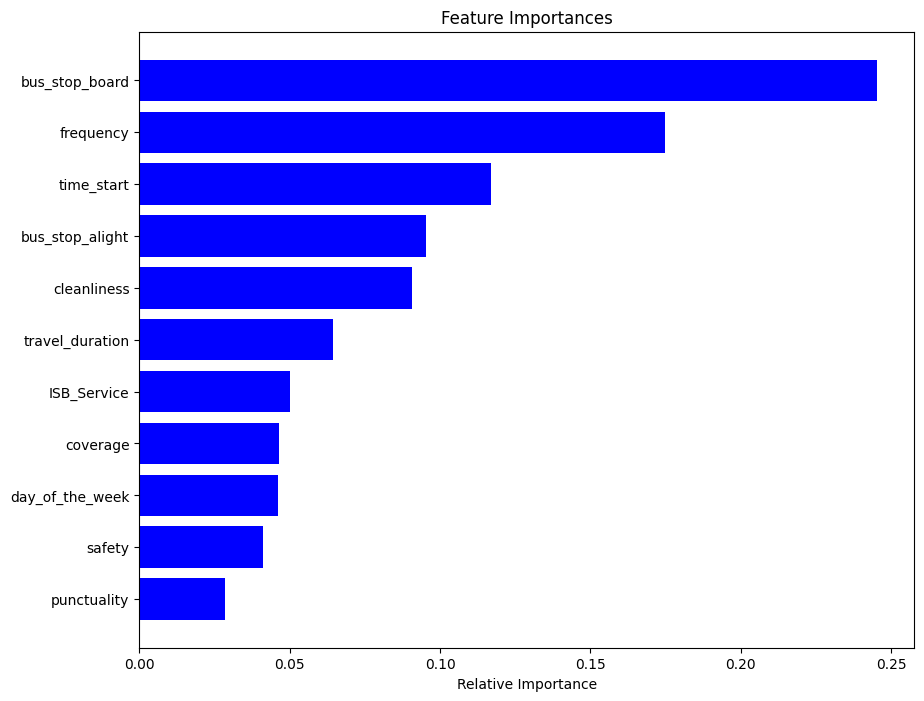

In [6]:
# Random Forest Regressor 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data into features and target 
X = data.drop(columns=['crowdedness'])
y = data['crowdedness']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R²): {r2}")

# Display feature importance
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [7]:
# Hyperparameter Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor()

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_est

/Users/LeeJingHuiMegan_1/Documents/Optimizing-Public-Transport-Data/.venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


/Users/LeeJingHuiMegan_1/Documents/Optimizing-Public-Transport-Data/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error: 11.463663194444445
Mean Squared Error: 218.21864648437497
Root Mean Squared Error: 14.772225508851907
R-squared (R²): 0.1763593895133112


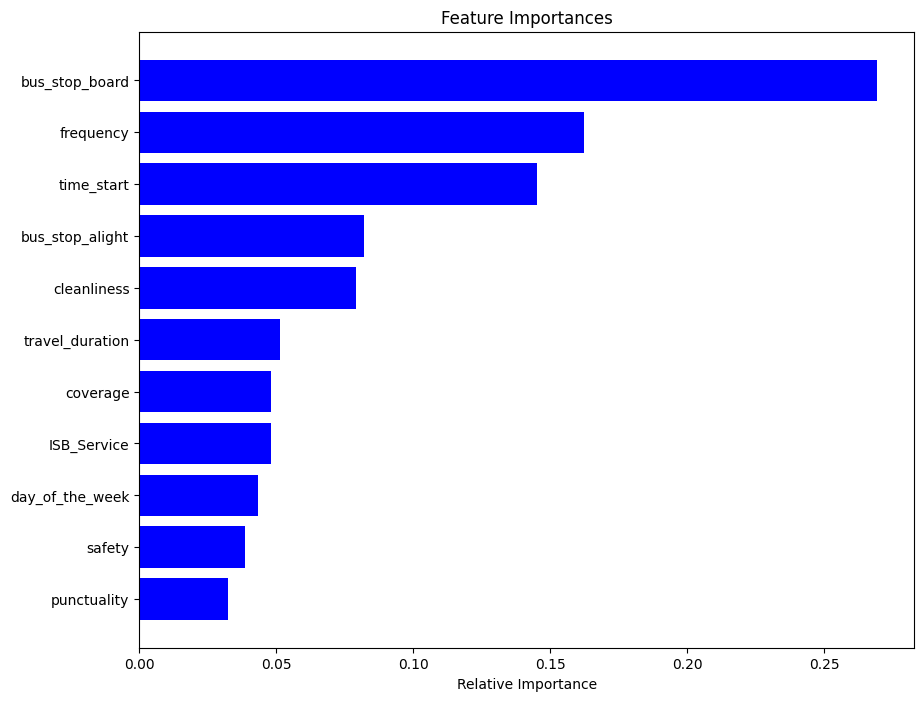

In [8]:
# Random Forest Regression after hyperparameter tuning
predictions = best_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R²): {r2}")

feature_importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Key Features: bus_stop_board, time_start, frequency, bus_stop_alight

In [9]:
# Feature selection
data_fs = data[['bus_stop_board', 'time_start', 'frequency', 'bus_stop_alight', 'crowdedness']]

# Split data into features and target 
X = data_fs.drop(columns=['crowdedness'])
y = data_fs['crowdedness']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_split=5, n_est

In [10]:
predictions = best_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error: 10.795306362040739
Mean Squared Error: 230.8266377453451
Root Mean Squared Error: 15.192979883661568
R-squared (R²): 0.12877200966976599


/Users/LeeJingHuiMegan_1/Documents/Optimizing-Public-Transport-Data/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
